# Vizualise similarities in sentence embeddings

Ici, je prends trois triplets de phrases. Dans chacun de ces triplets, j'ai 2 phrases qui sont volontairement similaires (qui veulent dire la même chose) et une parlant du même sujet mais qui n'a pas le même sens. Le but est double: premièrement analyser si les embeddings diffèrent dans un triplet donné on s'attend à ce que la phrase avec un un sens différent diffère des deux autres), ensuite vérifier que les phrases qui n'appartiennet pas au même triplet sont vraiment dissimilaires par leurs embeddings.

In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sn

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize, ha="center", va="center", fontweight="bold")
        return [tx]
Legend.update_default_handler_map({str : TextHandlerB()})

## 1. Implementation

### 1.1. Encode sentences

In [2]:
def encode_sentences(model_name_or_path, sentences):
    """
    Given a list of sentences an d a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """    
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in tokenized]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings[:torch.squeeze((masks == 1).nonzero(), dim=1).shape[0]], dim=0).numpy() for embeddings, masks in zip(last_hidden_states, attention_mask)]
    sentence_embeddings = np.array(sentence_embeddings)

    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_embeddings.shape[1])]
    df = pd.DataFrame(data=sentence_embeddings[:,:], columns=cols)
    df['Sentence'] = sentences
    return df

### 1.2. Cosine similarity matrix

In [3]:
def compute_cosine_matrix(embeddings):
    """
    """
    matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent in enumerate(sentences):
        for j, sent in enumerate(sentences):
            matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
    return matrix

### 1.3. Run all

In [30]:
def run(sentences, fig_name):
    """
    """
    #------------------
    # Encode sentences
    #-----------------
    print("BERT-base")
    bert_df = encode_sentences('bert-base-cased', sentences)
    print("NetBERT")
    netbert_df = encode_sentences('../_models/netbert-1027000/', sentences)

    #-------------------------
    # Get sentences embeddings
    #-------------------------
    bert_embeddings = bert_df.loc[:, bert_df.columns != 'Sentence'].values
    netbert_embeddings = netbert_df.loc[:, netbert_df.columns != 'Sentence'].values
    
    #-------------------------
    # Visualize cosine matrix
    #-------------------------
    bert_matrix = compute_cosine_matrix(bert_embeddings)
    netbert_matrix = compute_cosine_matrix(netbert_embeddings)
    
    labels = sentences
    ids = np.arange(1, len(labels)+1)
    bert_cm = pd.DataFrame(bert_matrix, index=ids, columns=ids)
    netbert_cm = pd.DataFrame(netbert_matrix, index=ids, columns=ids)

    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    sn.heatmap(bert_cm, annot=False, cmap="coolwarm", vmin=bert_matrix.min(), vmax=1.0, cbar=True)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20) #weight='semibold'
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20, rotation=0)
    ax1.set_xlabel("(a) BERT results.", fontsize=28, labelpad=20)

    ax2 = fig.add_subplot(1, 2, 2)
    sn.heatmap(netbert_cm, annot=False, cmap="coolwarm", vmax=1.0, cbar=True) #vmin=bert_matrix.min(),
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20) 
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20, rotation=0)
    ax2.set_xlabel("(b) NetBERT results.", fontsize=28, labelpad=20)
    
    legend = fig.legend(handles=list(map(str, ids)), labels=labels, title='Sentences', fontsize='18', loc='upper center', bbox_to_anchor=(0.5, 1.25))
    legend.get_title().set_fontsize('22') #legend 'Title' fontsize
    legend._legend_box.align = "left"
    fig.tight_layout()
    fig.show()
    fig.savefig("./figures/" + fig_name + ".pdf", bbox_inches='tight')
    return

## 2. Tests

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 13 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 13 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


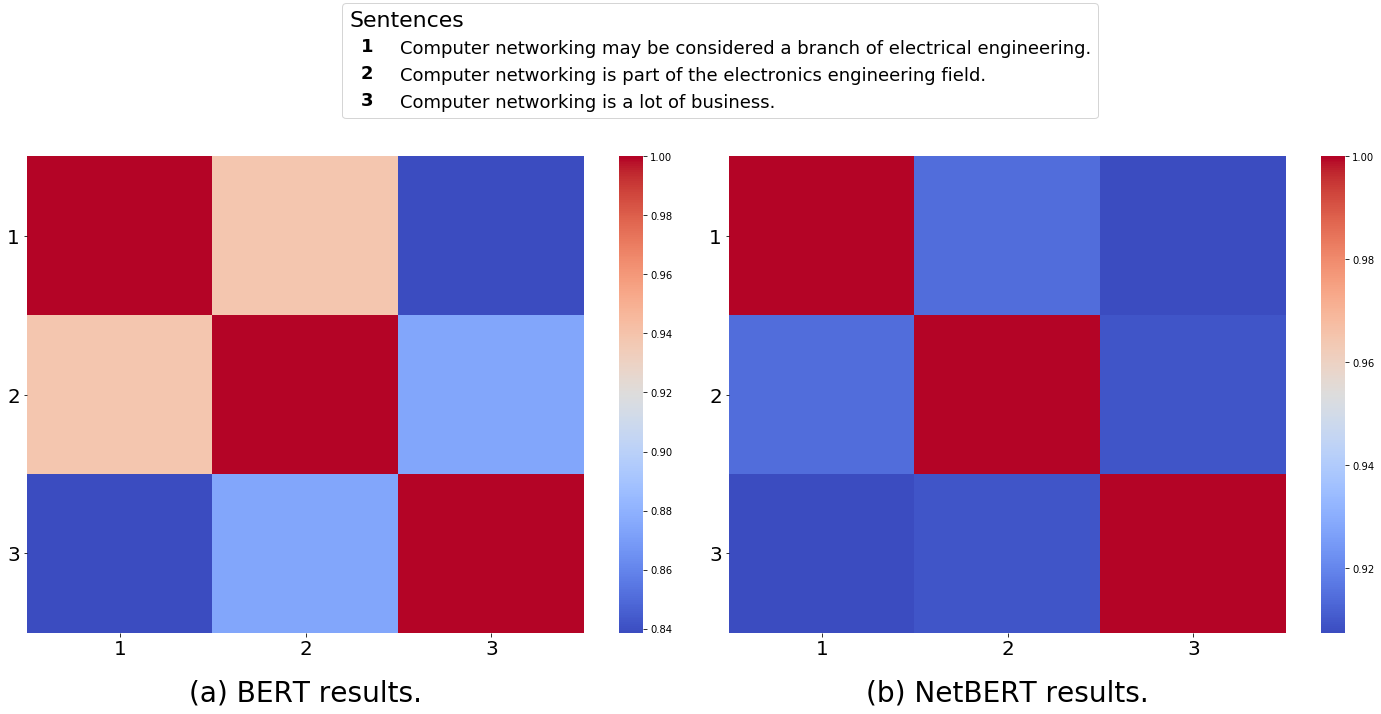

In [20]:
sentences = ['Computer networking may be considered a branch of electrical engineering.',
             'Computer networking is part of the electronics engineering field.',
             'Computer networking is a lot of business.']
run(sentences, fig_name="outlier_detection_networking")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 19 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


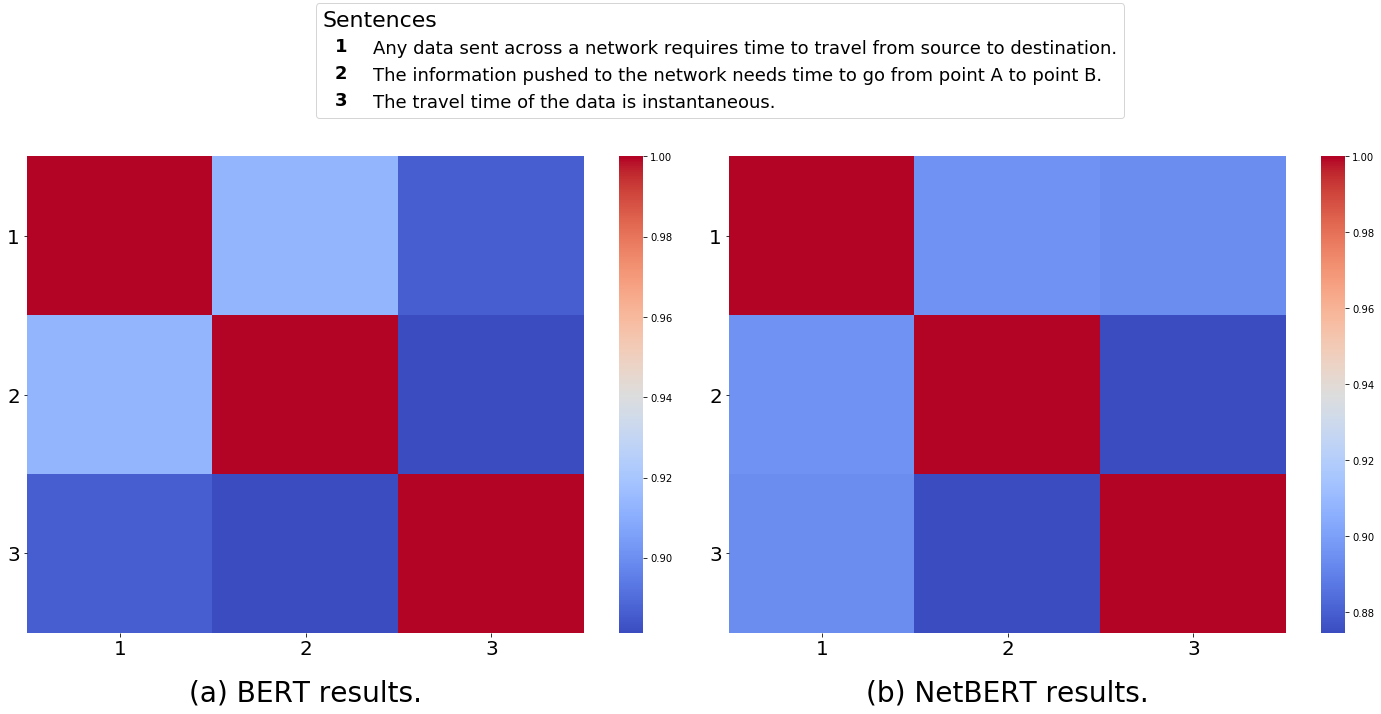

In [22]:
sentences = ['Any data sent across a network requires time to travel from source to destination.',
             'The information pushed to the network needs time to go from point A to point B.',
             'The travel time of the data is instantaneous.']
run(sentences, fig_name="outlier_detection_travel")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


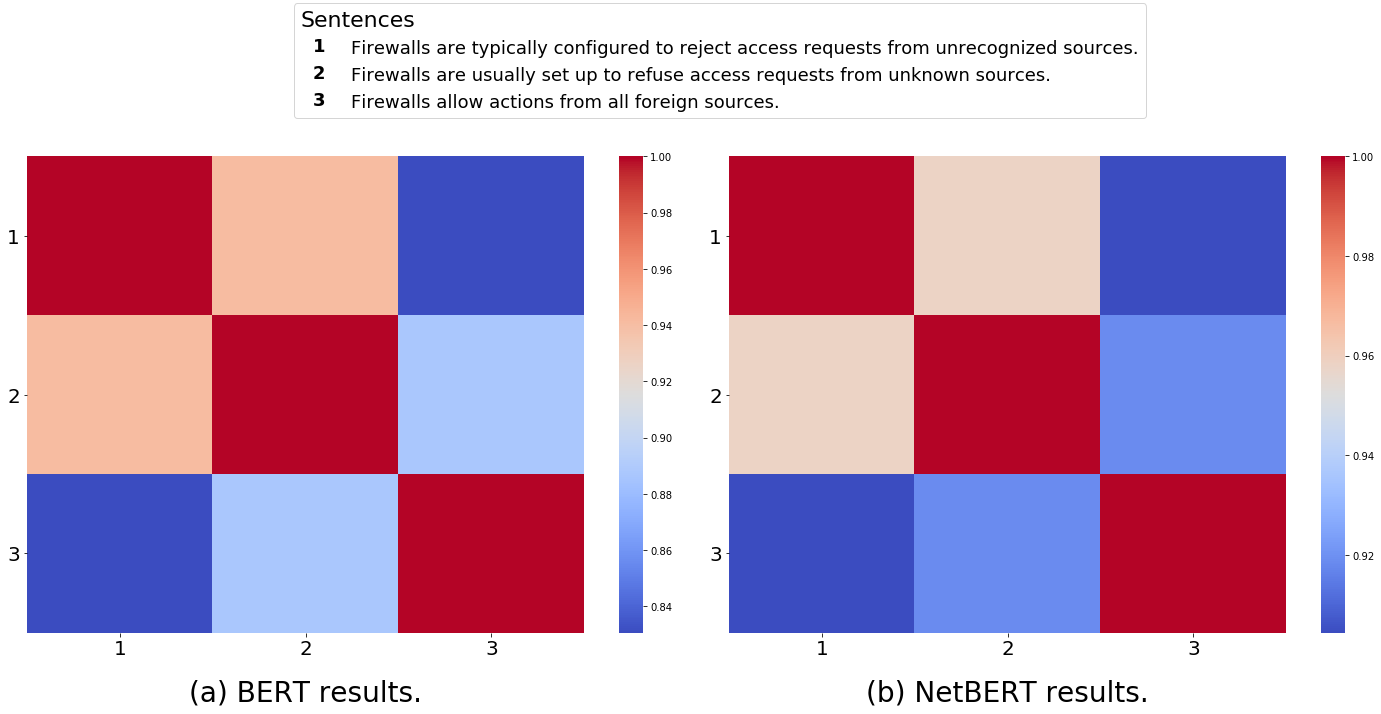

In [24]:
sentences = ['Firewalls are typically configured to reject access requests from unrecognized sources.',
             'Firewalls are usually set up to refuse access requests from unknown sources.',
             'Firewalls allow actions from all foreign sources.']
run(sentences, fig_name="outlier_detection_firewall")

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 21 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


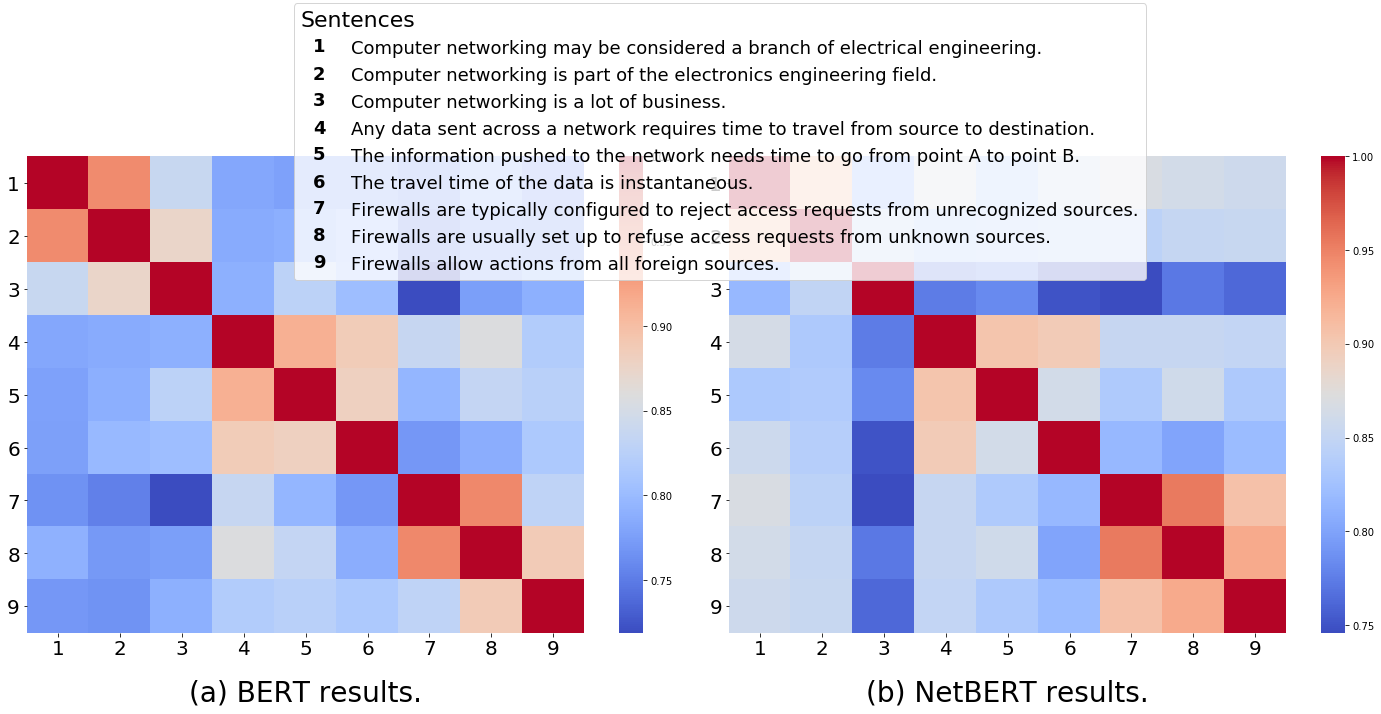

In [31]:
sentences = ['Computer networking may be considered a branch of electrical engineering.',
             'Computer networking is part of the electronics engineering field.',
             'Computer networking is a lot of business.',
             'Any data sent across a network requires time to travel from source to destination.',
             'The information pushed to the network needs time to go from point A to point B.',
             'The travel time of the data is instantaneous.',
             'Firewalls are typically configured to reject access requests from unrecognized sources.',
             'Firewalls are usually set up to refuse access requests from unknown sources.',
             'Firewalls allow actions from all foreign sources.'
]
run(sentences, fig_name="outlier_detection")

## Observations

* In the first square:
    - The two first sentences (the "similar" ones) are more similar according to BERT than NetBERT.
    - The third sentence ("dissimilar" one) is more dissimilar to the first two according to NetBERT.
* In the second square:
    - The third sentence ("dissimilar" one) is more dissimilar to the second one according to NetBERT.
* In the third square:
    - The third sentence ("dissimilar" one) is more dissimilar to the first one according to NetBERT.